In [2]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import seaborn as sns
from ema_workbench import (Scenario, MultiprocessingEvaluator, ScalarOutcome, ema_logging)
from ema_workbench import  Policy,Scenario,Constraint,Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated,
                                                     rebuild_platypus_population)
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from platypus import Hypervolume

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

# parameters for improved visualization
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("mordm/results_final/final_selected_policies.csv")
df.columns

Index(['0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1', '2_RfR 0', '2_RfR 1',
       '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1', 'A.4_Total Costs', 'A.4_Dike Investment Costs',
       'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths',
       'A.5_Total Costs', 'A.5_Dike Investment Costs',
       'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
       'RfR Total Costs', 'Expected Evacuation Costs', 'Overijssel_Deaths',
       'Overijssel_Damages', 'Overijssel_Investment', 'Overijssel_RfR_num',
       'Scenario', 'cluster', 'TotalCost'],
      dtype='object')

In [4]:
levers_name = ['0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1', '2_RfR 0', '2_RfR 1',
       '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1']

In [5]:
policies = df[levers_name]

In [6]:
policies.columns

Index(['0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1', '2_RfR 0', '2_RfR 1',
       '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1'],
      dtype='object')

In [7]:
debate_outcome = [1,0,0,0,1,0,
                  1,0,0,0,3,
                  0,0,0,
                  0,5,0,
                  5,0,5,
                  0]
debate_outcome_df = pd.DataFrame([debate_outcome], columns=levers_name)

In [8]:
debate_outcome_df

,0_RfR 0,0_RfR 1,1_RfR 0,1_RfR 1,2_RfR 0,2_RfR 1,3_RfR 0,3_RfR 1,4_RfR 0,4_RfR 1,...,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,5,0,5,0,5,0


In [9]:
complete_policies = pd.concat([policies, debate_outcome_df], ignore_index=True)

In [10]:
complete_policies

,0_RfR 0,0_RfR 1,1_RfR 0,1_RfR 1,2_RfR 0,2_RfR 1,3_RfR 0,3_RfR 1,4_RfR 0,4_RfR 1,...,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1
0,0,0,0,0,0,0,0,0,0,0,...,1,3,2,0,5,5,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,4,5,0,5,4,3,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,3,4,5,5,5,5,0,3,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,5,1,5,5,5,0
4,0,0,0,0,0,1,0,0,0,0,...,5,2,1,5,1,5,4,0,5,3
5,0,0,0,0,0,0,0,0,0,0,...,0,0,5,5,3,0,0,2,5,3
6,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,1,5,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,5,0,1,0,4,5,3,0,1
8,0,1,0,0,0,0,0,0,0,0,...,4,3,1,1,4,5,5,4,0,0
9,0,0,0,0,0,0,0,0,0,0,...,4,2,1,4,2,0,0,0,5,0


In [11]:
policies_to_evaluate = []

for i, policy in complete_policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [12]:
problem_formulation_id = 7
model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = model.uncertainties
outcomes = model.outcomes
levers = model.levers

In [13]:
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 2**8
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate,
                                            uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 9728 scenarios * 13 policies * 1 model(s) = 126464 experiments
100%|████████████████████████████████| 126464/126464 [1:29:49<00:00, 23.46it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [14]:
# save results
save_results(results, 'results/robustness_results2.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/racheldelvin/Desktop/epa141a-flood-policy-optimization-overijssel/final assignment/results/robustness_results2.tar.gz


In [15]:
results = load_results('results/robustness_results2.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/racheldelvin/Desktop/epa141a-flood-policy-optimization-overijssel/final assignment/results/robustness_results2.tar.gz


In [16]:
experiments, outcomes = results

## REGRET

In [17]:
def calculate_regret(data, best):
    return np.abs(best-data)

def calculate_stn_ratio(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        std = 1
    if direction == ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [18]:
overall_regret = {}
max_regret = {}

for outcome in model.outcomes:
    policy_column = experiments['policy']

    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.min(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

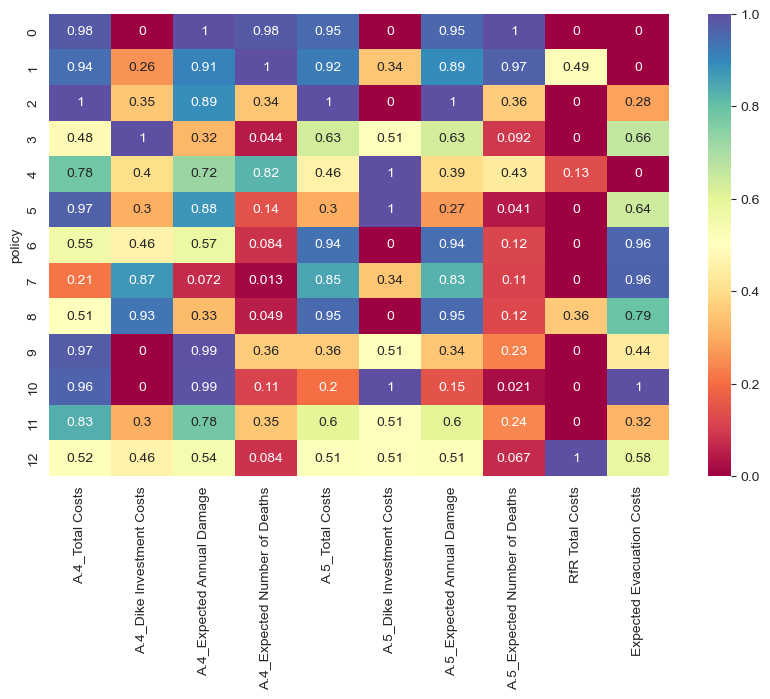

In [19]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='Spectral', annot=True)
plt.show()

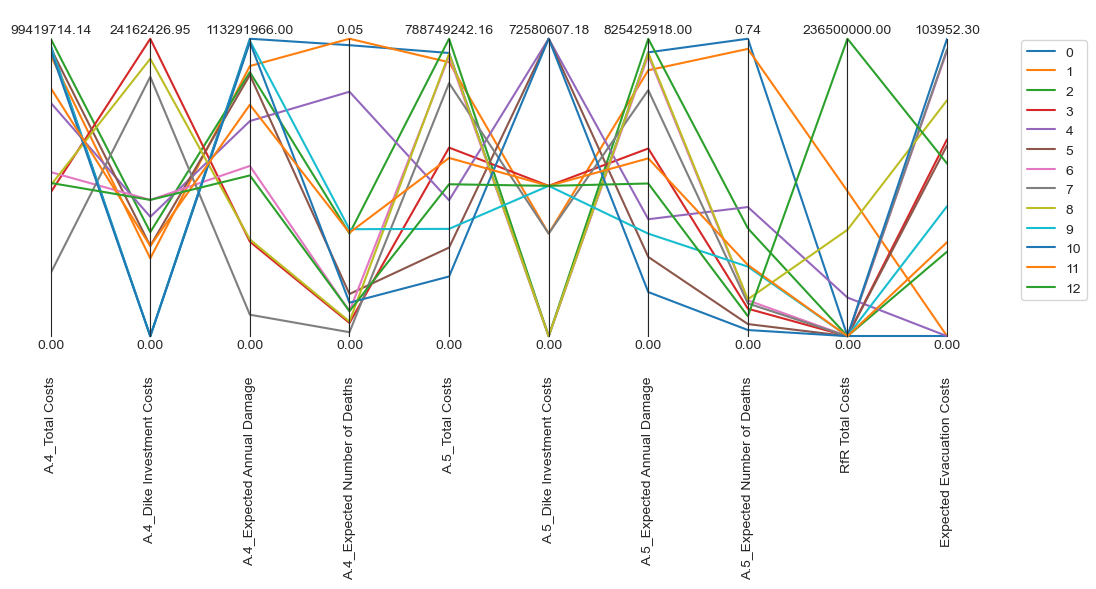

In [20]:
colors = sns.color_palette(n_colors=len(data))

data = max_regret

limits = parcoords.get_limits(data)
limits.loc[0, [
    'A.4_Total Costs','A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 
    'A.5_Total Costs','A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
    'RfR Total Costs', 'Expected Evacuation Costs'
]] = 0

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
plt.show()

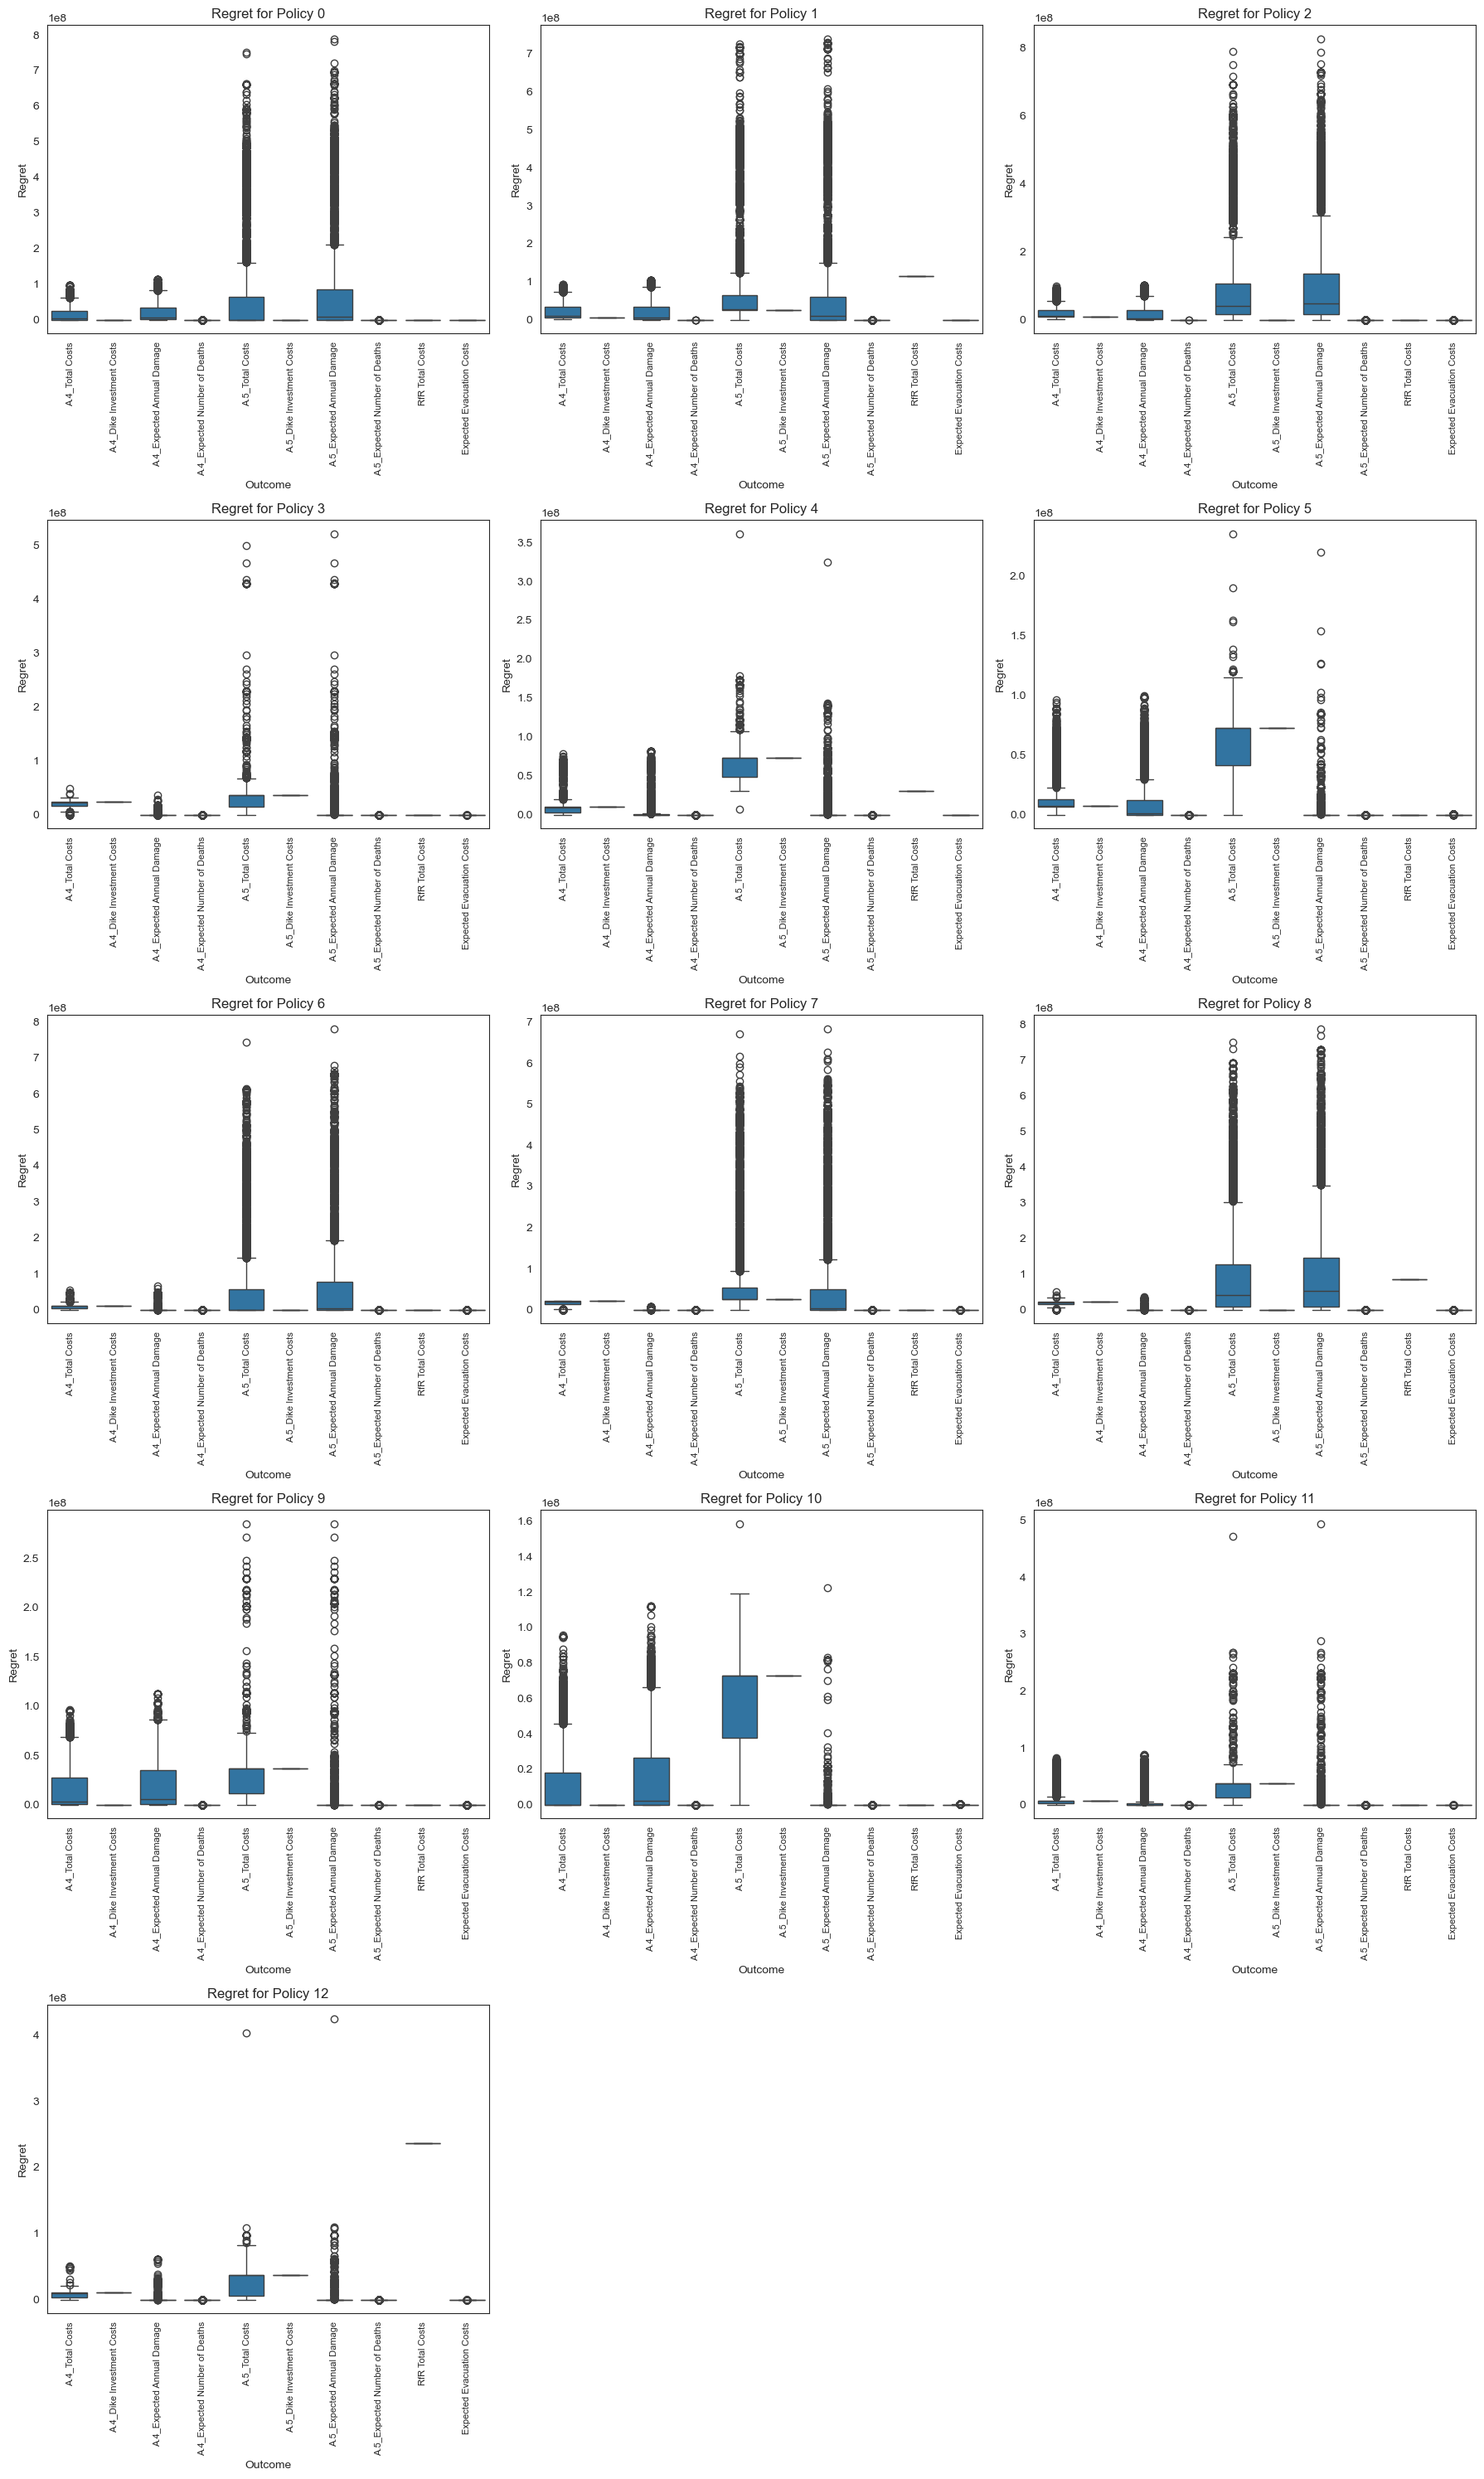

In [21]:
regret_records = []
for outcome_name, regret_df in overall_regret.items():
    for policy in regret_df.columns:
        for regret_value in regret_df[policy]:
            regret_records.append({
                'Outcome': outcome_name,
                'Policy': policy,
                'Regret': regret_value
            })
regret_long = pd.DataFrame(regret_records)

# Plot: one boxplot per policy, showing regret distributions for all outcomes
policies = regret_long['Policy'].unique()
n_policies = len(policies)
ncols = 3
nrows = int(np.ceil(n_policies / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), squeeze=False)
axes = axes.flatten()

for idx, policy in enumerate(policies):
    ax = axes[idx]
    data = regret_long[regret_long['Policy'] == policy]
    sns.boxplot(data=data, x='Outcome', y='Regret', ax=ax)
    ax.set_title(f'Regret for Policy {policy}')
    ax.tick_params(axis='x', rotation=90, labelsize=8)

# Hide any unused subplots
for i in range(n_policies, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## SIGNAL-TO-NOISE RATIO

In [22]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = calculate_stn_ratio(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,5.702606e+14,0.000000e+00,5.702606e+14,1.934589e-04,1.206855e+16,0.000000,1.206855e+16,1.629422e-02,0.0,0.000000e+00
1,6.724539e+14,1.177341e-02,5.077385e+14,1.757963e-04,1.195186e+16,0.093271,8.695199e+15,1.159621e-02,115300000.0,0.000000e+00
2,5.083011e+14,1.574570e-02,3.289958e+14,1.495921e-05,1.809854e+16,0.000000,1.809854e+16,3.168056e-03,0.0,4.358814e+07
3,8.645073e+13,9.001205e-02,1.984835e+12,1.038717e-08,1.341068e+15,0.273263,1.806904e+14,4.241626e-06,0.0,9.774676e+07
4,1.651762e+14,1.805871e-02,4.363719e+13,1.574407e-05,1.344017e+15,1.081535,6.151881e+13,9.423843e-05,30700000.0,0.000000e+00
5,3.798521e+14,1.365706e-02,2.309447e+14,1.780332e-06,9.546810e+14,1.081535,1.934456e+13,7.636150e-07,0.0,1.079314e+08
6,8.896511e+13,1.106877e+07,8.311866e+12,3.740269e-08,9.936120e+15,0.000000,9.936120e+15,1.950640e-04,0.0,3.302059e+08
7,7.182706e+13,7.848672e-02,1.320303e+12,6.438791e-09,9.556002e+15,0.093271,6.682120e+15,1.302455e-04,0.0,3.872464e+08
8,1.002734e+14,2.253757e+07,3.447896e+12,1.879931e-08,1.969369e+16,0.000000,1.969369e+16,3.794906e-04,84600000.0,3.383608e+08
9,6.008174e+14,0.000000e+00,6.008174e+14,2.664116e-05,1.007239e+15,0.273263,9.566372e+13,1.946089e-05,0.0,5.384868e+07


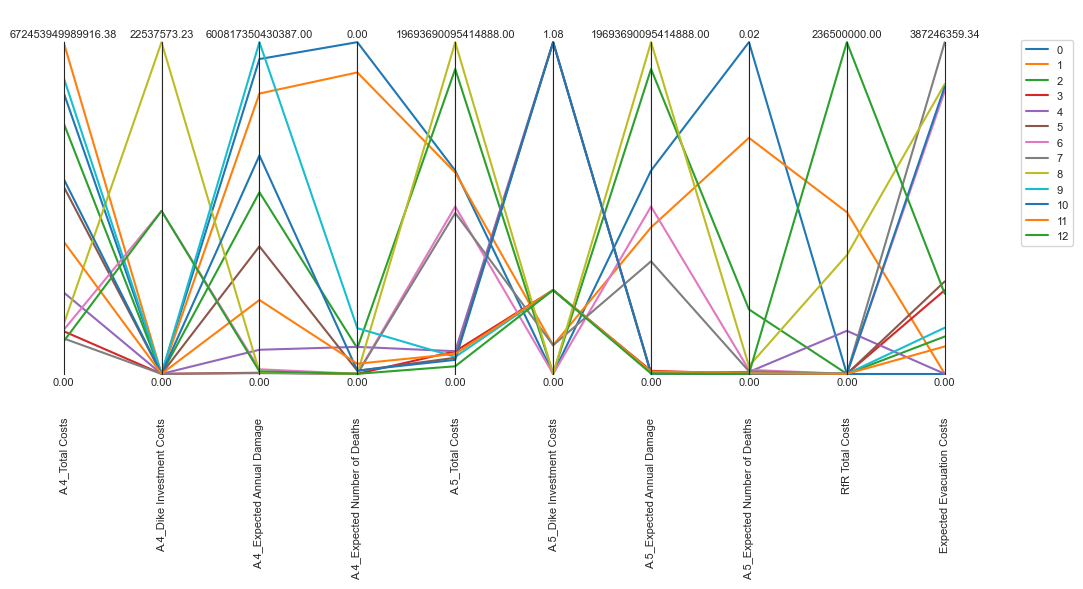

In [23]:
data = scores
colors = sns.color_palette(n_colors=len(data))
limits = parcoords.get_limits(data)
limits.loc[0, [
    'A.4_Total Costs','A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 
    'A.5_Total Costs','A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
    'RfR Total Costs', 'Expected Evacuation Costs'
]] = 0

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=8)

# Plot each policy with a label for the legend
for idx, (policy, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(policy), color=colors[idx])
paraxes.legend()
plt.show()

## SATISFICING

In [24]:
policy_medians = {}

for policy in np.unique(experiments['policy']):
    mask = experiments['policy'] == policy
    medians = {}
    for outcome in model.outcomes:
        values = outcomes[outcome.name][mask]
        medians[outcome.name] = np.median(values)
    policy_medians[policy] = medians

policy_medians_df = pd.DataFrame(policy_medians).T

In [25]:
thresholds = {
    'A.4_Total Costs': 20000000,
    'A.4_Expected Number of Deaths': 0.01,
    'A.4_Expected Annual Damage': 1000000,
    'A.4_Dike Investment Costs': 11000000,
    'A.5_Total Costs': 20000000,
    'A.5_Expected Number of Deaths': 0.01,
    'A.5_Expected Annual Damage': 10000000,
    'A.5_Dike Investment Costs': 35000000,
    'RfR Total Costs': 150000000,
    'Expected Evacuation Costs': 50000000,
}

satisficing_bool = {}

for policy in np.unique(experiments['policy']):
    mask = experiments['policy'] == policy
    outcome_bools = {}
    for outcome in model.outcomes:
        values = outcomes[outcome.name][mask]
        # True if all scenarios for this policy meet the threshold
        outcome_bools[outcome.name] = np.all(values <= thresholds[outcome.name])
    satisficing_bool[policy] = outcome_bools

satisficing_bool_df = pd.DataFrame.from_dict(satisficing_bool, orient='index')
satisficing_bool_df

,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,False,True,False,False,False,True,False,False,True,True
1,False,True,False,False,False,True,False,False,True,True
2,False,True,False,False,False,True,False,False,True,True
3,False,False,False,True,False,False,False,False,True,True
4,False,True,False,False,False,False,False,False,True,True
5,False,True,False,True,False,False,False,False,True,True
6,False,False,False,True,False,True,False,False,True,True
7,False,False,False,True,False,True,False,False,True,True
8,False,False,False,True,False,True,False,False,True,True
9,False,True,False,False,False,False,False,False,True,True


In [26]:
# Count number of True per policy
satisficing_bool_df['n_satisficing'] = satisficing_bool_df.sum(axis=1)

# Find the policy (row) with the most True values
max_true = satisficing_bool_df['n_satisficing'].max()
satisficing_policies = satisficing_bool_df[satisficing_bool_df['n_satisficing'] == max_true]

print(f"Maximum number of satisficing outcomes: {max_true}")
satisficing_policies

Maximum number of satisficing outcomes: 4


,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,n_satisficing
0,False,True,False,False,False,True,False,False,True,True,4
1,False,True,False,False,False,True,False,False,True,True,4
2,False,True,False,False,False,True,False,False,True,True,4
5,False,True,False,True,False,False,False,False,True,True,4
6,False,False,False,True,False,True,False,False,True,True,4
7,False,False,False,True,False,True,False,False,True,True,4
8,False,False,False,True,False,True,False,False,True,True,4
10,False,True,False,True,False,False,False,False,True,True,4


In [27]:
# Find all policies that are True for both death outcomes
filtered = satisficing_bool_df[
    (satisficing_bool_df['A.4_Expected Number of Deaths']) &
    (satisficing_bool_df['A.5_Expected Number of Deaths'])
]

filtered

,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,n_satisficing


In [28]:
thresholds = {
    'A.4_Total Costs': 20000000,
    'A.4_Expected Number of Deaths': 0.01,
    'A.4_Expected Annual Damage': 1000000,
    'A.4_Dike Investment Costs': 11000000,
    'A.5_Total Costs': 20000000,
    'A.5_Expected Number of Deaths': 0.04, # 0.04 IS THE SMALLEST
    'A.5_Expected Annual Damage': 10000000,
    'A.5_Dike Investment Costs': 35000000,
    'RfR Total Costs': 150000000,
    'Expected Evacuation Costs': 50000000,
}

satisficing_bool = {}

for policy in np.unique(experiments['policy']):
    mask = experiments['policy'] == policy
    outcome_bools = {}
    for outcome in model.outcomes:
        values = outcomes[outcome.name][mask]
        # True if all scenarios for this policy meet the threshold
        outcome_bools[outcome.name] = np.all(values <= thresholds[outcome.name])
    satisficing_bool[policy] = outcome_bools

satisficing_bool_df = pd.DataFrame.from_dict(satisficing_bool, orient='index')
satisficing_bool_df

,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,False,True,False,False,False,True,False,False,True,True
1,False,True,False,False,False,True,False,False,True,True
2,False,True,False,False,False,True,False,False,True,True
3,False,False,False,True,False,False,False,False,True,True
4,False,True,False,False,False,False,False,False,True,True
5,False,True,False,True,False,False,False,False,True,True
6,False,False,False,True,False,True,False,False,True,True
7,False,False,False,True,False,True,False,False,True,True
8,False,False,False,True,False,True,False,False,True,True
9,False,True,False,False,False,False,False,False,True,True


In [29]:
# Find all policies that are True for both death outcomes
filtered = satisficing_bool_df[
    (satisficing_bool_df['A.4_Expected Number of Deaths']) &
    (satisficing_bool_df['A.5_Expected Number of Deaths'])
]

filtered

,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs


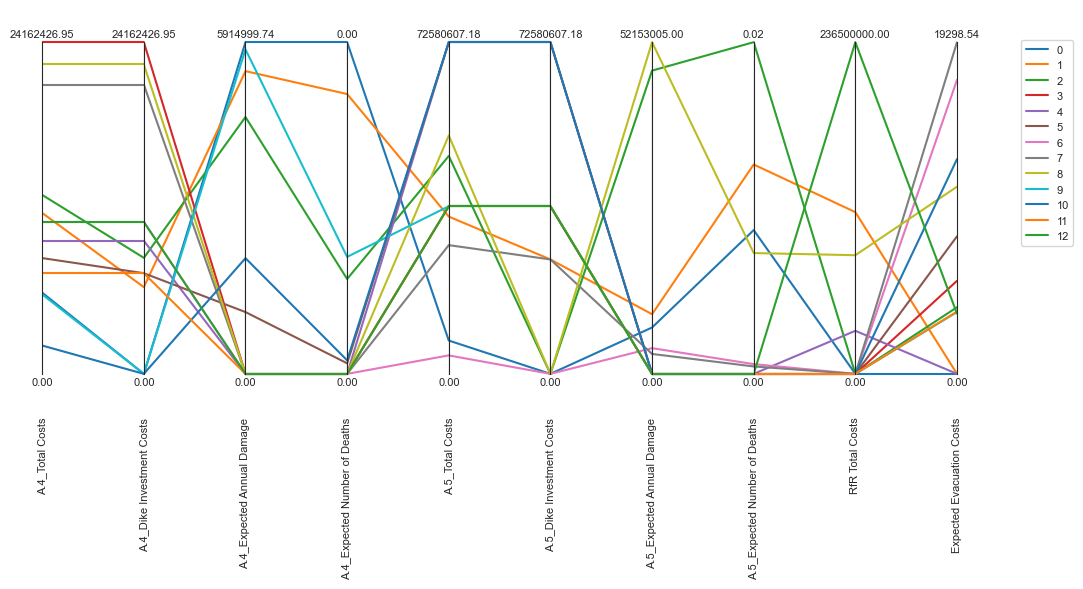

In [30]:
data = policy_medians_df  # Each row: policy, Each column: outcome
colors = sns.color_palette(n_colors=len(data))

limits = parcoords.get_limits(data)
limits.loc[0, [
    'A.4_Total Costs','A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 
    'A.5_Total Costs','A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
    'RfR Total Costs', 'Expected Evacuation Costs'
]] = 0

paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=8)

for idx, (policy, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(policy), color=colors[idx])

paraxes.legend()
plt.show()

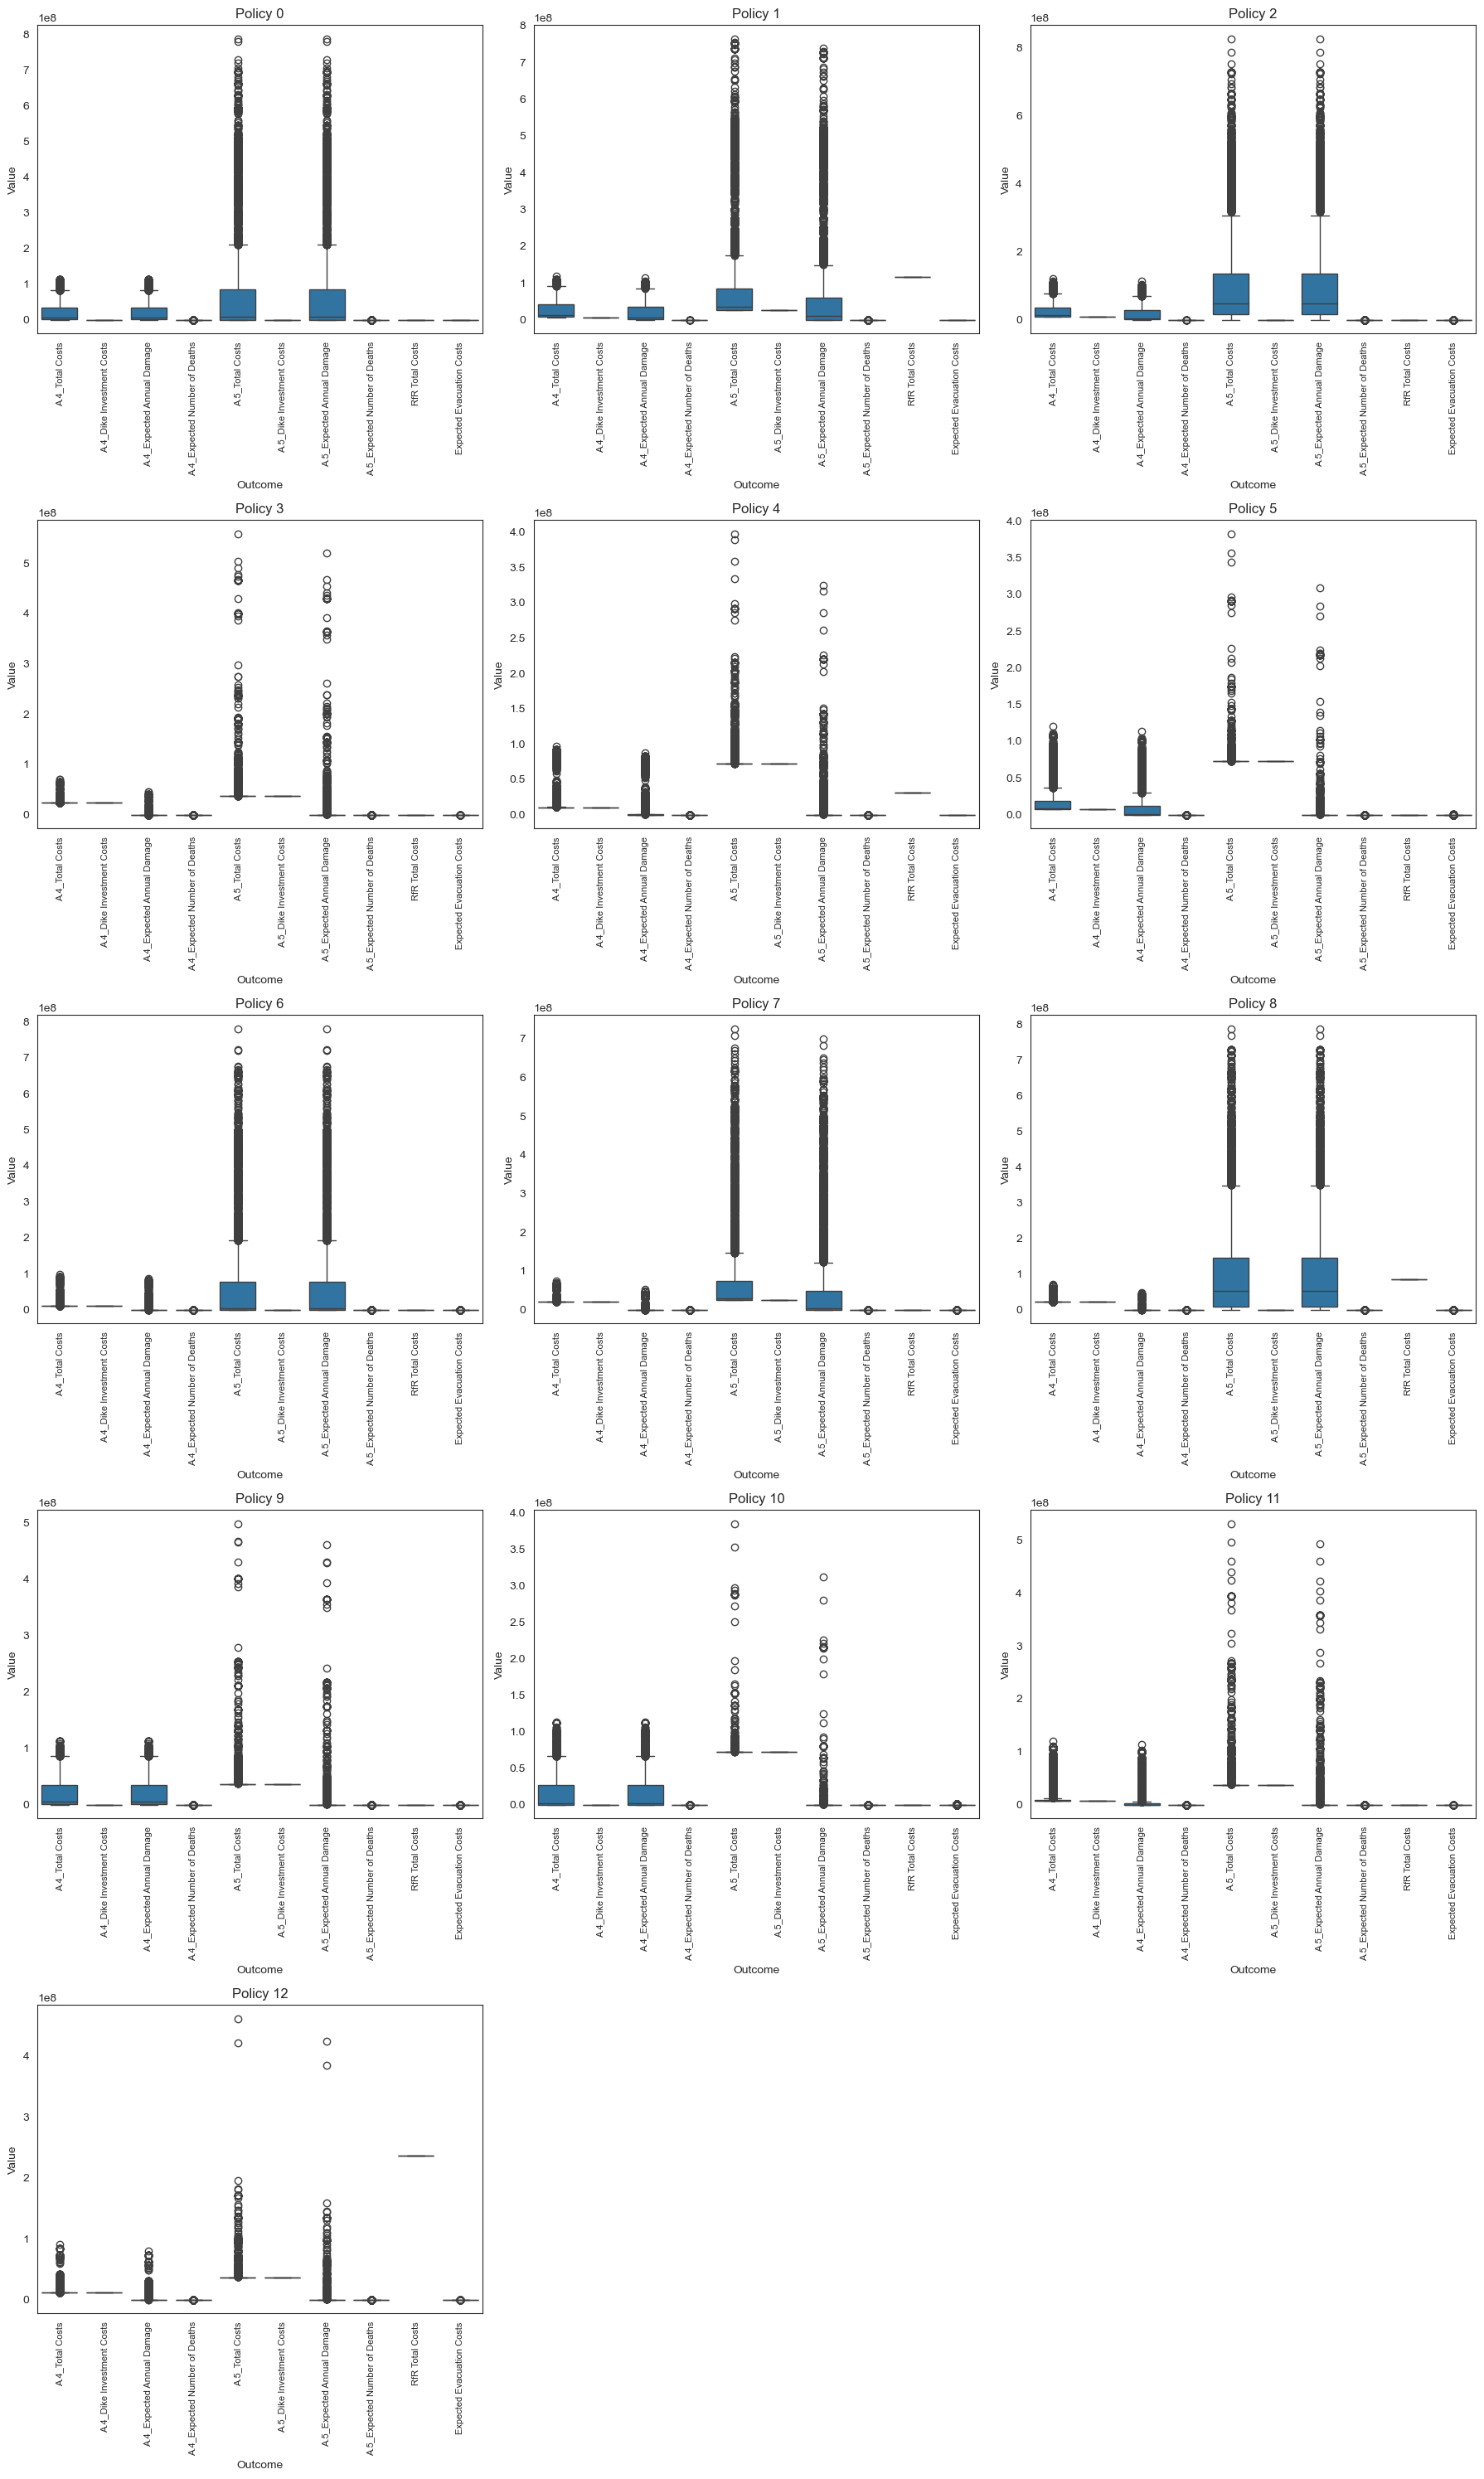

In [31]:
outcome_cols = [
    'A.4_Total Costs','A.4_Dike Investment Costs', 'A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 
    'A.5_Total Costs','A.5_Dike Investment Costs', 'A.5_Expected Annual Damage', 'A.5_Expected Number of Deaths',
    'RfR Total Costs', 'Expected Evacuation Costs'
]

policies = np.unique(experiments['policy'])
n_policies = len(policies)
ncols = 3
nrows = int(np.ceil(n_policies / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), squeeze=False)
axes = axes.flatten()

for idx, policy in enumerate(policies):
    mask = experiments['policy'] == policy
    records = []
    for outcome in outcome_cols:
        for value in outcomes[outcome][mask]:
            records.append({'Outcome': outcome, 'Value': value})
    df_policy = pd.DataFrame(records)
    ax = axes[idx]
    sns.boxplot(data=df_policy, x='Outcome', y='Value', ax=ax)
    ax.set_title(f'Policy {policy}')
    ax.tick_params(axis='x', rotation=90, labelsize=8)

# Hide any unused subplots
for i in range(n_policies, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()